# BART Fine-tuning to generate Code Documentation

The objective of this notevook is to fine tune the BART Model to be able to generate code documentation. The dataset used to fine tune is CodeSearchNet.

## Import Libraries

In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=990ebe1bde2b8fb6b2d671c4d727beb327b917d41721b4fc389374f830eb3f78
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("code_search_net", "java", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

java.zip:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/454451 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26909 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15328 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 454451
    })
    test: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 26909
    })
    validation: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
        num_rows: 15328
    })
})


In [ ]:
dataset['train']

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 454451
})

In [ ]:
train_dataset = dataset["train"].shuffle(seed=42)
validation_dataset = dataset["validation"].shuffle(seed=42)
test_dataset = dataset["test"].shuffle(seed=42)

## Training

In [ ]:
# Set up the BART Model

from transformers import BartForConditionalGeneration, BartTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments

model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset

def preprocess_function(examples):
    inputs = tokenizer(examples["func_code_string"], truncation=True, padding="max_length", max_length=256)
    outputs = tokenizer(examples["func_documentation_string"], truncation=True, padding="max_length", max_length=256)
    inputs["labels"] = outputs["input_ids"]
    return inputs

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

tokenized_dataset = {
    "train": tokenized_train_dataset,
    "validation": tokenized_validation_dataset,
    "test": tokenized_test_dataset,
}

Map:   0%|          | 0/454451 [00:00<?, ? examples/s]

Map:   0%|          | 0/15328 [00:00<?, ? examples/s]

Map:   0%|          | 0/26909 [00:00<?, ? examples/s]

In [ ]:
# Split into train/validation/test
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["validation"]

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-code-doc",
    evaluation_strategy="steps",         # Evaluate on validation set every epoch
    logging_dir="./logs",
    per_device_train_batch_size=32,      # Batch size per device
    per_device_eval_batch_size=32,       # Evaluation batch size
    num_train_epochs=1,                  # Number of epochs
    learning_rate=5e-5,                  # Learning rate
    weight_decay=0.01,
    report_to="wandb",
    save_total_limit=2,
    predict_with_generate=True,
    logging_steps=100,                   # Log every 100 steps
    run_name="bart_code_documentation_java",
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

# Save the final model
model.save_pretrained("./bart-code-doc")
tokenizer.save_pretrained("./bart-code-doc")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-9ff69c99b056>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss
100,0.780500,0.731746
200,0.662800,0.698664
300,0.646800,0.674091
400,0.609500,0.664723
500,0.611700,0.652793
600,0.584100,0.643482
700,0.574900,0.639512
800,0.549300,0.632271
900,0.552500,0.630527
1000,0.550700,0.622789


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./bart-code-doc/tokenizer_config.json',
 './bart-code-doc/special_tokens_map.json',
 './bart-code-doc/vocab.json',
 './bart-code-doc/merges.txt',
 './bart-code-doc/added_tokens.json')

## Inference

In [ ]:
# Inference on single point

import torch

image = test_dataset[700]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
inputs = tokenizer(image["func_code_string"], return_tensors="pt", max_length=256, truncation=True).to(device)

outputs = model.generate(
    inputs["input_ids"],
    max_length=128,
    num_beams=5,
    early_stopping=True
)

generated_doc = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Documentation:", generated_doc)

Generated Documentation: Sets the {@link BindingImpl} to be annotated with the given annotation.

@param annotation the annotation to set
@return the binding


In [ ]:
def clear_cuda():
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

        with torch.cuda.device('cuda'):
            torch.cuda.empty_cache()

if torch.cuda.is_available():
    print("Clearing CUDA memory...")
    clear_cuda()
    print("CUDA memory cleared.")

Clearing CUDA memory...
CUDA memory cleared.


## Performance Metrics

In [ ]:
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def batched_generate_docs(model, tokenizer, codes, batch_size):
    results = []
    for i in tqdm(range(0, len(codes), batch_size), desc="Processing Batches"):
        batch = codes[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", max_length=256, truncation=True, padding="max_length")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Generate predictions
        with torch.no_grad():
            summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
        decoded = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        results.extend(decoded)

    return results

# Prepare the test dataset
codes = [example['func_code_string'] for example in test_dataset]
expected_comments = [example['func_documentation_string'] for example in test_dataset]

# Run batched inference
batch_size = 16
predicted_comments = batched_generate_docs(model, tokenizer, codes, batch_size=batch_size)

# Compare predictions with ground truth and create a DataFrame
results = []
for code, expected_comment, predicted_comment in zip(codes, expected_comments, predicted_comments):
    is_equal = predicted_comment.strip() == expected_comment.strip()
    results.append({
        "code": code,
        "expected_comment": expected_comment,
        "predicted_comment": predicted_comment,
        "is_equal": is_equal
    })

df = pd.DataFrame(results)
df.to_csv('batched_code_doc_inference_results.csv', index=False)
print(df.head())

Processing Batches: 100%|██████████| 1682/1682 [1:01:20<00:00,  2.19s/it]


                                                code  \
0  public static String getRootExpression(Node ex...   
1  public void setSelectedStation(String id) {\n ...   
2  private void readServerElement_1_0(final XMLEx...   
3  protected JSONObject executeString(\n\t\t\tHtt...   
4  public com.google.cloud.datastore.Key createRa...   

                                    expected_comment  \
0  Convenience method called by many different pr...   
1  Looks for the station with given id. If found,...   
2  Read the <server/> element based on version 1....   
3  Submit the {@code stringParam} as HTTP request...   
4  Construct a Key from a Long or String id\n@par...   

                                   predicted_comment  is_equal  
0  /*\n(non-Javadoc)\n\n@see org.apache.ojb.lang....     False  
1  Sets the selected station.\n\n@param id the st...     False  
2  Reads the first element of a list of model nod...     False  
3  Execute a string.\n\n@param httpMethodParam\nt...     False  
4

Calculating BLEU scores for each datapoint

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_scores(df):
    bleu_scores = []

    for predicted, actual in zip(df['predicted_comment'], df['expected_comment']):
        reference = [actual.split()]
        candidate = predicted.split()

        # Calculate BLEU score for 1-gram
        score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
        bleu_scores.append(score)

    return bleu_scores

df['BLEU Score'] = calculate_bleu_scores(df)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
df.head()

,code,expected_comment,predicted_comment,is_equal,BLEU Score
0,public static String getRootExpression(Node ex...,Convenience method called by many different pr...,/*\n(non-Javadoc)\n\n@see org.apache.ojb.lang....,False,0.000000
1,public void setSelectedStation(String id) {\n ...,"Looks for the station with given id. If found,...",Sets the selected station.\n\n@param id the st...,False,0.163502
2,private void readServerElement_1_0(final XMLEx...,Read the <server/> element based on version 1....,Reads the first element of a list of model nod...,False,0.256233
3,protected JSONObject executeString(\n\t\t\tHtt...,Submit the {@code stringParam} as HTTP request...,Execute a string.\n\n@param httpMethodParam\nt...,False,0.006091
4,public com.google.cloud.datastore.Key createRa...,Construct a Key from a Long or String id\n@par...,Creates a new {@link com.google.cloud.datastor...,False,0.166667


Calculate ROUGE-1 scores for each datapoint

In [ ]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(df):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    rouge_scores = []

    for predicted, actual in zip(df['predicted_comment'], df['expected_comment']):
        scores = scorer.score(actual, predicted)
        rouge_scores.append(scores['rouge1'].fmeasure)  # Focusing on F-measure for ROUGE-1

    return rouge_scores

df['ROUGE-1 F Score'] = calculate_rouge_scores(df)

In [ ]:
bleu_mean = df['BLEU Score'].mean()
bleu_min = df['BLEU Score'].min()
bleu_max = df['BLEU Score'].max()

rouge_mean = df['ROUGE-1 F Score'].mean()
rouge_min = df['ROUGE-1 F Score'].min()
rouge_max = df['ROUGE-1 F Score'].max()

print(f"BLEU Score - Mean: {bleu_mean:.4f}, Min: {bleu_min:.4f}, Max: {bleu_max:.4f}")
print(f"ROUGE-1 F Score - Mean: {rouge_mean:.4f}, Min: {rouge_min:.4f}, Max: {rouge_max:.4f}")

BLEU Score - Mean: 0.1622, Min: 0.0000, Max: 1.0000
ROUGE-1 F Score - Mean: 0.3008, Min: 0.0000, Max: 1.0000


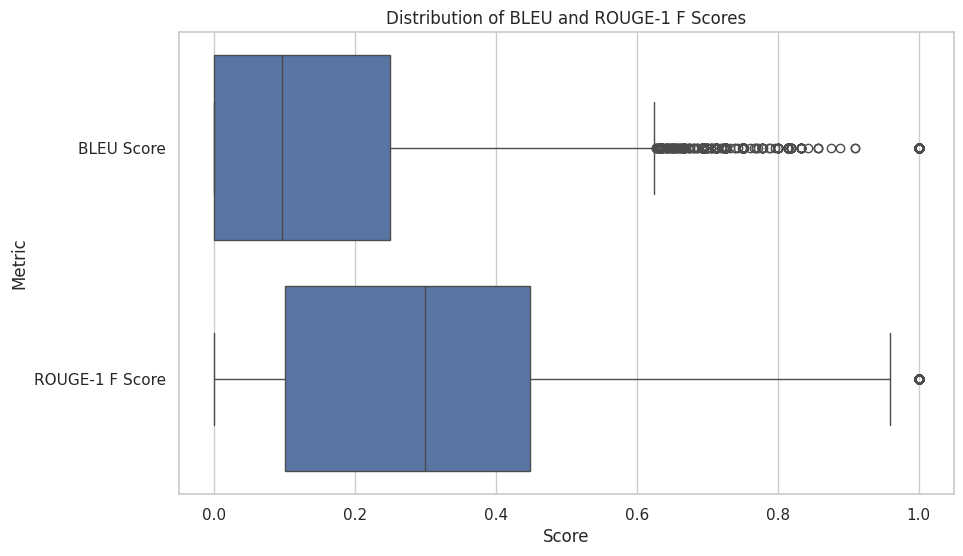

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

long_df = df.melt(value_vars=['BLEU Score', 'ROUGE-1 F Score'],
                          var_name='Metric', value_name='Score')

sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='Metric', data=long_df, orient='h')

plt.title('Distribution of BLEU and ROUGE-1 F Scores')
plt.xlabel('Score')
plt.ylabel('Metric')

plt.show()